In [1]:
from pathlib import Path
import cv2 as cv
import torch
import numpy as np

frame_path = Path("/home/ozden/repos/Video2World/src/utils/dog.jpg")
depth_path = Path("/home/ozden/repos/Video2World/src/utils/depth.npy")

frame = cv.imread(frame_path)  # returns None if file unreadable
if frame is None:
    raise FileNotFoundError(f"Image not found or unreadable: {frame_path}")
frame = torch.Tensor(frame)

if not depth_path.exists:
    raise FileNotFoundError(f"Depth file not found: {depth_path}")
    
depth = np.load(depth_path)
depth = torch.Tensor(depth)

In [10]:
x = torch.arange(frame.shape[1])
y = torch.arange(frame.shape[0])
xy = torch.cartesian_prod(x, y)
z = depth.flatten().unsqueeze(-1)

#print(f"x.shape: {x.shape} | y.shape: {y.shape} | xy.shape: {xy.shape} | z.shape: {z.shape}")
coords = torch.cat([xy, z], dim=1).unsqueeze(-1)
print(coords.shape)

torch.Size([1875298, 3, 1])


In [3]:
import sys
sys.path.append("..")   # or project root

from src.utils.points import ImagePoints

img_pts = ImagePoints(frame, depth)


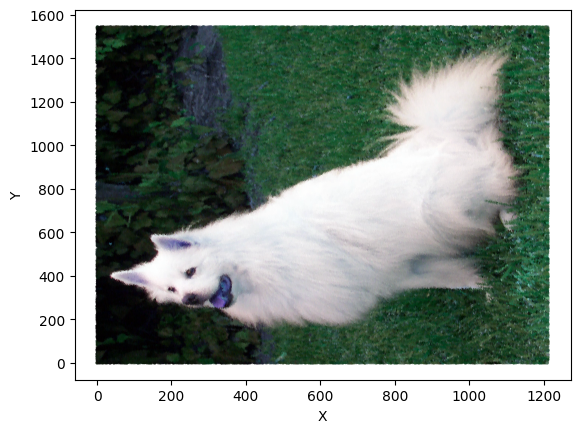

In [ ]:
img_pts.scatter(step=10)

In [11]:
import torch


# =========================================================
# Utility: compute Gaussian weights
# =========================================================
def gaussian_weight(grid, mu, inv_cov):
    """
    grid   : [H,W,2]  pixel coordinates
    mu     : [2]
    inv_cov: [2,2]

    returns:
        weight map [H,W]
    """

    diff = grid - mu                     # [H,W,2]

    # quadratic form (x-μ)^T Σ^{-1} (x-μ)
    q = torch.einsum('...i,ij,...j->...', diff, inv_cov, diff)

    return torch.exp(-0.5 * q)


# =========================================================
# Main splatting function
# =========================================================
def gaussian_splat(
        mu,         # [N,2]
        cov,        # [N,2,2]
        color,      # [N,3]
        alpha,      # [N,1]
        image_size  # (H,W)
):
    """
    Renders 2D Gaussian splats into an image.

    Inputs:
        mu        : centers (pixel space)
        cov       : covariance per Gaussian
        color     : RGB in [0,1]
        alpha     : opacity in [0,1]
        image_size: output resolution

    Returns:
        image : [H,W,3]
    """

    device = mu.device
    H, W = image_size

    # output image
    image = torch.zeros(H, W, 3, device=device)

    # precompute inverse covariances
    inv_cov = torch.linalg.inv(cov)   # [N,2,2]

    N = mu.shape[0]

    # -----------------------------------------------------
    # Loop per Gaussian (only small local area processed)
    # -----------------------------------------------------
    for i in range(N):

        cx, cy = mu[i]
        Sigma_inv = inv_cov[i]

        # ----------------------------------------------
        # compute 3σ bounding box (support region)
        # ----------------------------------------------
        sigma = torch.sqrt(torch.diagonal(cov[i]))
        rx = int(3 * sigma[0].item())
        ry = int(3 * sigma[1].item())

        xmin = max(int(cx.item()) - rx, 0)
        xmax = min(int(cx.item()) + rx + 1, W)

        ymin = max(int(cy.item()) - ry, 0)
        ymax = min(int(cy.item()) + ry + 1, H)

        if xmin >= xmax or ymin >= ymax:
            continue

        # ----------------------------------------------
        # local pixel grid
        # ----------------------------------------------
        xs = torch.arange(xmin, xmax, device=device)
        ys = torch.arange(ymin, ymax, device=device)

        yy, xx = torch.meshgrid(ys, xs, indexing='ij')

        grid = torch.stack([xx, yy], dim=-1).float()  # [h,w,2]

        # ----------------------------------------------
        # evaluate gaussian
        # ----------------------------------------------
        w = gaussian_weight(grid, mu[i], Sigma_inv)   # [h,w]

        # ----------------------------------------------
        # alpha blending
        # ----------------------------------------------
        w = w.unsqueeze(-1) * alpha[i]   # [h,w,1]

        image[ymin:ymax, xmin:xmax] += w * color[i]

    return image.clamp(0, 1)


# =========================================================
# Example usage
# =========================================================
if __name__ == "__main__":

    device = "cuda"

    N = 5000
    H, W = 512, 512

    mu = torch.rand(N, 2, device=device)
    mu[:, 0] *= W
    mu[:, 1] *= H

    # small isotropic covariances
    sigma = 3.0
    cov = torch.eye(2, device=device).unsqueeze(0).repeat(N,1,1) * sigma**2

    color = torch.rand(N, 3, device=device)
    alpha = torch.ones(N, 1, device=device) * 0.6

    img = gaussian_splat(mu, cov, color, alpha, (H, W))

    print(img.shape)


torch.Size([512, 512, 3])


In [13]:
import torch

D, H, W = 4, 5, 6
z, y, x = torch.meshgrid(
    torch.arange(D, device='cuda'),
    torch.arange(H, device='cuda'),
    torch.arange(W, device='cuda'),
    indexing='ij'
)
indices = torch.stack([z, y, x], dim=-1)

print(indices.shape)
print(indices[1, 2, 1, :])

torch.Size([4, 5, 6, 3])
tensor([1, 2, 1], device='cuda:0')


In [ ]:
import torch

x = torch.rand((2, 3, 4))
mask = (x > 0.5)

y = mask * x

print(x)
print(y)





tensor([[[0.5159, 0.9197, 0.8543, 0.8511],
         [0.5934, 0.1269, 0.1971, 0.5750],
         [0.2035, 0.2808, 0.9145, 0.7703]],

        [[0.7972, 0.8067, 0.5789, 0.8986],
         [0.7212, 0.6522, 0.3277, 0.2231],
         [0.4010, 0.5263, 0.1980, 0.0189]]])
tensor([[[0.5159, 0.9197, 0.8543, 0.8511],
         [0.5934, 0.0000, 0.0000, 0.5750],
         [0.0000, 0.0000, 0.9145, 0.7703]],

        [[0.7972, 0.8067, 0.5789, 0.8986],
         [0.7212, 0.6522, 0.0000, 0.0000],
         [0.0000, 0.5263, 0.0000, 0.0000]]])


In [25]:
import torch

x = torch.randn(20, 30, 40, device='cuda')
x[:5] = 0          # simulate zero padding
x[:, :3] = 0
x[:, :, :7] = 0

mask = (x != 0)
coords = mask.nonzero(as_tuple=False)

z_min, y_min, x_min = coords.min(dim=0).values
z_max, y_max, x_max = coords.max(dim=0).values

print(f"Non-zero region: z[{z_min}:{z_max+1}], y[{y_min}:{y_max+1}], x[{x_min}:{x_max+1}]")

Non-zero region: z[5:20], y[3:30], x[7:40]


In [8]:
import torch

x = torch.randn(5, 9, device='cuda')
y = torch.randn(9, device='cuda')

z = torch.einsum('ni,i->n', x, y)

print(f"x: {x}")
print(f"y: {y}")
print(f"z: {z}")


x: tensor([[ 0.3456,  1.9356,  1.0902,  1.0644, -1.1224,  0.5666, -0.2587, -1.3111,
          0.4082],
        [ 1.6328, -1.2761, -0.7719, -0.6876, -2.8144,  1.7921, -0.5207, -0.7895,
          1.3760],
        [ 0.8999,  0.7861, -0.1108, -1.0594, -0.9924, -0.2950,  2.3136, -0.7215,
          0.9125],
        [-0.3611,  0.6437,  1.5033,  0.1565, -0.0184, -1.6706,  0.2536,  2.0232,
         -0.9072],
        [ 0.4155, -0.2535,  0.9401,  0.9102, -1.1563,  0.6275, -0.4971, -1.0965,
         -0.3885]], device='cuda:0')
y: tensor([-0.3465, -1.6794, -0.2946, -1.0086,  0.5252, -1.7366, -0.2145,  1.2999,
         0.3509], device='cuda:0')
z: tensor([-7.8443, -2.5237, -1.6535,  3.5922, -4.0653], device='cuda:0')


In [1]:
import open3d as o3d
import numpy as np

# Create random 3D points
points = np.random.rand(10000, 3)

# Convert to Open3D format
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Visualize
o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [1]:
from v2w.datasets.split import split_tum_vi_dataset
from v2w.utils.logger import setup_logging
import logging

run_dir = setup_logging("experimentA")

logger = logging.getLogger(__name__)
logger.info("Experiment started")
logger.info("Logs stored in %s", run_dir)


split_tum_vi_dataset(
    root="/home/ozden/repos/Video2World/data/tum_vi/raw/dataset-corridor4_512_16",
    split_dir="/home/ozden/repos/Video2World/data/tum_vi/splits",
    split_ratios={'train': 0.8, 'val': 0.1, 'test': 0.1}
)



2026-02-26 02:30:14,843 | INFO | __main__ | Experiment started
2026-02-26 02:30:14,845 | INFO | __main__ | Logs stored in logs/2026-02-26_02-30-14_experimentA
/home/ozden/repos/Video2World/src/v2w/datasets/split.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rot_tensor = torch.tensor(rot)


In [ ]:
import torch
from v2w.geometry.points import SFMPointCloud
from v2w.geometry.reconstruction import reconstruct_volume_from_video_frames

frame_path = "/home/ozden/repos/Video2World/data/tum_vi/splits/test"

bounds = torch.tensor(
    [[0., 100.],
     [0., 100.],
     [0., 100.]]
)
res = torch.tensor([0.1, 0.1, 0.1])
sfm_pcd = SFMPointCloud(
    bounds=bounds, 
    res=res, 
    downsampling_digit=2,
    device='cuda'
    )

sfm_pcd = reconstruct_volume_from_video_frames(sfm_pcd, frame_path)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
f.name: camera
f.name: intrinsic
f.name: f_mm
f.name: sensor_width_mm
f.name: sensor_height_mm
f.name: width_px
f.name: height_px
f.name: extrinsic
f.name: csv_data_path


In [1]:
from v2w.io import load_tum_vi_frame_csv, load_tum_vi_extrinsics_csv
import numpy as np

def nearest_match(t1, t2):
    scale, offset = np.polyfit(t1, t2[:len(t1)], 1)
    t1 = scale * t1 + offset
    
    t1 = np.asarray(t1)
    t2 = np.asarray(t2)

    indices = np.searchsorted(t2, t1)

    indices = np.clip(indices, 1, len(t2) - 1)

    left = t2[indices - 1]
    right = t2[indices]

    indices -= (t1 - left < right - t1)

    return indices

mocap0_path = "/home/ozden/repos/Video2World/data/tum_vi/raw/dataset-corridor4_512_16/mav0/cam1/data.csv"
t_mocap0, _ = load_tum_vi_frame_csv(mocap0_path)

cam1_path = "/home/ozden/repos/Video2World/data/tum_vi/raw/dataset-corridor4_512_16/mav0/mocap0/data.csv"
t_cam1, _, _ = load_tum_vi_extrinsics_csv(cam1_path)

indices = nearest_match(np.array(t_mocap0), np.array(t_cam1))
print(indices)

[   0    1    2 ... 1924 1925 1926]
